In [96]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import torchvision
import time


In [97]:
data_dir = '/home/antpc/cough_detection/dataset/melspectograms/melspectrograms'

In [98]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=2)

classes = ['cough', 'no_cough']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


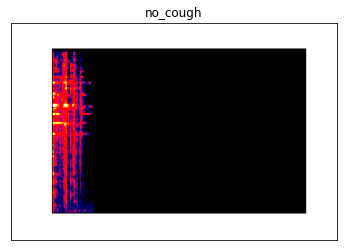

In [99]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1,1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [100]:
model = models.vgg16(pretrained=False)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [101]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True
    
n_inputs = model.classifier[6].in_features

last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer

print(model.classifier[6].out_features)
print(model)

criterion = torch.nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.000001)

model.to(device);

True
2
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [102]:
epochs = 10
steps = 0
running_loss = 0
train_losses, test_losses,accuracy_acc = [], [],[]
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_acc.append(accuracy/len(testloader))
                    
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0
        model.train()
print("Time required: "+str(time.time() - start)+" seconds")

Epoch: 1/10..  Training Loss: 0.183..  Test Loss: 0.098..  Test Accuracy: 0.980
Epoch: 2/10..  Training Loss: 0.099..  Test Loss: 0.098..  Test Accuracy: 0.980
Epoch: 3/10..  Training Loss: 0.099..  Test Loss: 0.098..  Test Accuracy: 0.980
Epoch: 4/10..  Training Loss: 0.100..  Test Loss: 0.099..  Test Accuracy: 0.980
Epoch: 5/10..  Training Loss: 0.097..  Test Loss: 0.097..  Test Accuracy: 0.980
Epoch: 6/10..  Training Loss: 0.097..  Test Loss: 0.096..  Test Accuracy: 0.980
Epoch: 7/10..  Training Loss: 0.098..  Test Loss: 0.096..  Test Accuracy: 0.980
Epoch: 8/10..  Training Loss: 0.095..  Test Loss: 0.096..  Test Accuracy: 0.980
Epoch: 9/10..  Training Loss: 0.097..  Test Loss: 0.095..  Test Accuracy: 0.980
Epoch: 10/10..  Training Loss: 0.094..  Test Loss: 0.095..  Test Accuracy: 0.980
Time required: 413.40302658081055 seconds


In [103]:
PATH = '/home/antpc/cough_detection/codes/vgg16.pt'
torch.save(model.state_dict(), PATH)
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[ 5.7931e-02, -6.6413e-02, -4.1243e-02],
                        [-5.3842e-03, -2.5107e-02,  8.9223e-02],
                        [-2.2056e-02, -7.9060e-02, -6.6987e-02]],
              
                       [[-3.0123e-02,  1.1166e-01,  1.3337e-02],
                        [ 2.4471e-02, -4.5492e-02,  7.8690e-02],
                        [ 6.5569e-02,  8.1893e-02,  6.2156e-02]],
              
                       [[ 1.0480e-01,  3.8075e-02, -3.9985e-02],
                        [-4.1587e-02,  1.1945e-02, -9.3953e-03],
                        [ 8.5931e-02,  1.0345e-01,  6.9629e-02]]],
              
              
                      [[[ 7.8563e-02,  4.1377e-02, -4.4121e-02],
                        [ 1.9318e-02,  8.6025e-02, -4.9219e-02],
                        [-5.2731e-02,  4.3162e-02,  7.3558e-02]],
              
                       [[-3.1695e-02,  8.1090e-02,  1.7735e-02],
                        [-9.2536e-02,  3

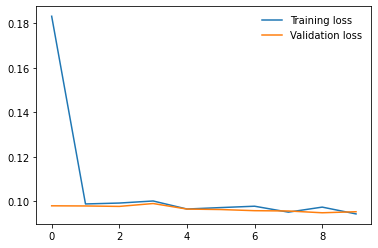

In [104]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

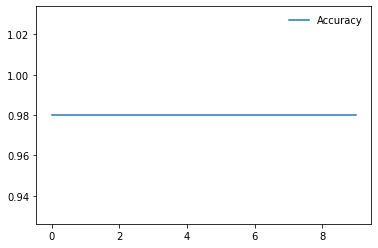

In [105]:
plt.plot(accuracy_acc, label='Accuracy')
plt.legend(frameon=False)


tensor([[-2.0998,  1.9075]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1], device='cuda:0')
1
Prediciton no_cough
True class no_cough


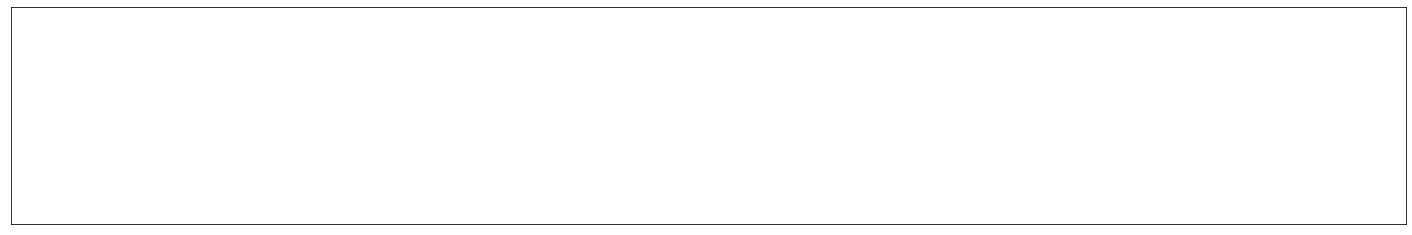

In [106]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()

images.numpy()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()

# getting sample outputs
output = model(images)
print(output)
# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
#remove single dimensional entries
print(preds)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    print("Prediciton "+classes[preds])
    print("True class "+classes[labels])